In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import h5py
print(torch.cuda.is_available())

True


In [2]:
import hls4ml
test = hls4ml.converters.get_supported_pytorch_layers()
print('MaxPool2d' in test)
print('MaxPool1d' in test)

print(test)


2023-08-19 19:40:29.547149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 19:40:30.060201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True
True
['cat', 'concat', 'concatenate', 'add', 'mul', 'multiply', 'sub', 'subtract', 'fmin', 'minimum', 'fmax', 'maximum', 'Linear', 'Softmax', 'ReLU', 'LeakyReLU', 'Threshold', 'ELU', 'PReLU', 'Sigmoid', 'Tanh', 'BatchNorm2d', 'BatchNorm1d', 'Batch_norm', 'Flatten', 'View', 'MaxPool1d', 'MaxPool2d', 'AvgPool1d', 'AvgPool2d', 'Conv1d', 'Conv2d']


In [3]:
class LeNet5(nn.Module):
     def __init__(self,num_classes, testing=False):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(48, 48)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(48, 24)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(24, num_classes)
        # self.func = func
        self.testing=testing
        self.flatten=nn.Flatten()

     def forward(self, x):
        # print(f'input layer{x.shape}')
        out = self.layer1(x)
        # print(f'layer1 {out.shape}')
        out = self.layer2(out)
        # print(f'layer2 {out.shape}')
        out=self.flatten(out)
        # print(f'flatten {out.shape}')
        out = self.fc(out)
        # print(f'linear1 {out.shape}')
        out = self.relu(out)
        out = self.fc1(out)
        # print(f'linear2 {out.shape}')
        out = self.relu1(out)
        embedding = self.fc2(out)
        # print(f'final {embedding.shape}')
        # embedding[:,4]=(math.pi/4)*(nn.Tanh()(embedding[:,4]) + 1)
        # final=self.func(embedding)
        
        if self.testing==True:
            return out, embedding, final 
        
        # return final
        return embedding

    


In [4]:
model_pytorch=LeNet5(5)
model_pytorch.load_state_dict(torch.load('PytorchLeNet2.pt'))
model_pytorch.eval() 

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=48, out_features=48, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=48, out_features=24, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=24, out_features=5, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [5]:
path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'

with h5py.File(path, 'r') as h5:
    img = h5['growth_1']['spot_2']['raw_image'][1]
    img= img/img.max()
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()
print(img_tensor.shape)
with torch.no_grad():
    output_pytorch = model_pytorch(img_tensor)
print(output_pytorch)

torch.Size([1, 1, 29, 48])
tensor([[15.2126, 14.8477, 10.9690,  7.2814,  0.4322]])


In [6]:

config = hls4ml.utils.config_from_pytorch_model(model_pytorch, inputs_channel_last=True,transpose_outputs=False,default_reuse_factor=2 )

model_hls = hls4ml.converters.convert_from_pytorch_model(model_pytorch, [[None,1,29,48]], hls_config=config, output_dir='my-hls-test', project_name='myproject', part='xcku035-fbva676-2-e', io_type='io_stream' )
model_hls.compile()



Interpreting Model ...
Topology:
Layer name: layer1_0, layer type: Conv2D, input shape: [[None, 1, 29, 48]]
Layer name: layer1_1, layer type: BatchNormalization, input shape: [[None, 6, 25, 44]]
Layer name: layer1_2, layer type: Activation, input shape: [[None, 6, 25, 44]]
Layer name: layer1_3, layer type: MaxPooling2D, input shape: [[None, 6, 25, 44]]
Layer name: layer2_0, layer type: Conv2D, input shape: [[None, 6, 6, 11]]
Layer name: layer2_1, layer type: BatchNormalization, input shape: [[None, 16, 2, 7]]
Layer name: layer2_2, layer type: Activation, input shape: [[None, 16, 2, 7]]
Layer name: layer2_3, layer type: MaxPooling2D, input shape: [[None, 16, 2, 7]]
Layer name: flatten, layer type: Reshape, input shape: [[None, 16, 1, 3]]
Layer name: fc, layer type: Dense, input shape: [[None, 48]]
Layer name: relu, layer type: Activation, input shape: [[None, 48]]
Layer name: fc1, layer type: Dense, input shape: [[None, 48]]
Layer name: relu1, layer type: Activation, input shape: [[None

In [40]:
#To set path:
#in terminal, write "export PATH=/home/ferroelectric/"
#then "export PATH=/home/ferroelectric/Xilinx_2018/Vivado/2018.3/bin:$PATH"
#and " export PATH=/bin:/ferroelectric/bin:$PATH"- this adds which function

#to run build from the command line: vivado_hls -f build_prj.tcl "reset=0 csim=1 synth=1 cosim=0 validation=0 vsynth=0 export=0"

In [20]:
hls4ml.report.read_vivado_report('my-hls-test')

Found 1 solution(s) in my-hls-test/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
1.9873 1.3252 1.48145 0.849609 0.451172 1.9873 1.3252 1.48145 0.849609 0.451172 1.9873 1.3252 1.48145 0.849609 0.451172 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133 0.25 0.503906 0.0761719 0.342773 0.286133

In [2]:
#HLS Predict --> save results --> put into tb_output_predictions---> .savetext function ---> every 5 values on a new line
#Space deliminated
#input features-greyscale image--> reshape/flatten them, each on a new line --> one image worth of values on each line--> numpy.savetext 

#manually compare CSIM results and HLS Results 

In [48]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

def gaussian(img_dim,params):
    params=np.array(params)
    mean_x, mean_y, cov_x, cov_y, theta = params
    
    x = np.arange(img_dim[1], dtype=np.float32)
    y = np.arange(img_dim[0], dtype=np.float32)
    x, y = np.meshgrid(x, y)

    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)

    x = np.repeat(x, 1, axis=0)
    y = np.repeat(y, 1, axis=0)

    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rota_matrix = np.reshape(rota_matrix, (1, 2, 2))

    xy = np.stack([x - mean_x, y - mean_y], axis=-1)
    xy = np.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = np.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x**2) + xy[:, :, :, 1]**2 / (cov_y**2)))
    return img[0,:,:]


path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'

with h5py.File(path, 'r') as h5:
    data = h5['growth_4']['spot_2']['raw_image'][1]

# Reshape the data to (1, 1, 29, 48)
data=data/255.0
data_reshaped = data.reshape((1, 29, 48, 1))
# data= torch.tensor(np.float32(data)).cuda()

y=model_hls.predict(data_reshaped)


print(y)


[11.47167969 14.06835938 13.08789062  7.0625      1.16308594]


In [49]:
import numpy as np
# from sklearn.metrics import mean_squared_error
mse=np.square(np.subtract(data, gaussian((29,48),y))).mean()


print(mse)

0.08276604494835305


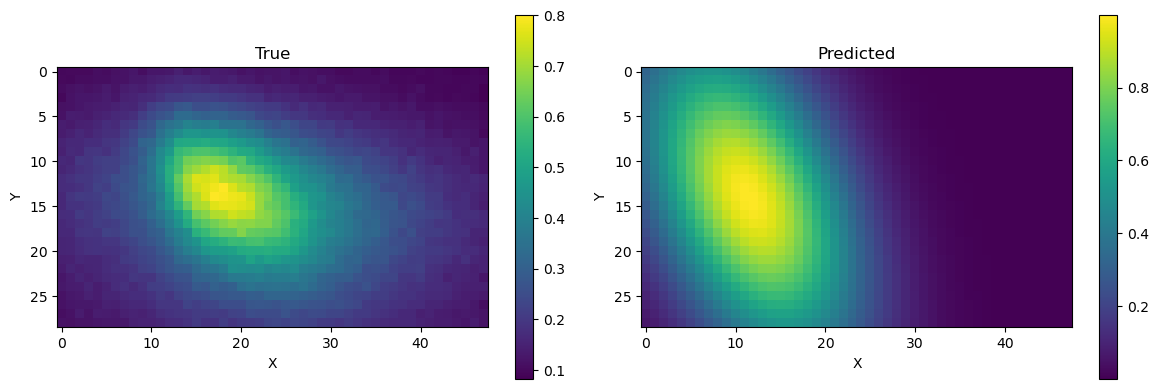

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
im0 = axs[0].imshow(data)
axs[0].set_title(f'True')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
fig.colorbar(im0, ax=axs[0])

    # Plot predicted image
im1 = axs[1].imshow(gaussian((29,48),y))
axs[1].set_title(f'Predicted')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
fig.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

In [57]:
import h5py
import numpy as np

# Load images from HDF5 file
def load_images_from_hdf5(hdf5_filename):
    with h5py.File(hdf5_filename, 'r') as hdf5_file:
        images = hdf5_file['growth_1']['spot_2']['raw_image'][:]  # Adjust the dataset name as per your file structure
    return images


# Normalize and flatten images
def preprocess_images(images):
    normalized_images = images / 255.0  # Normalize pixel values to [0, 1]
    
    flattened_images = normalized_images.reshape(images.shape[0], -1)
    return flattened_images

path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
# Load images from HDF5 file
input_images = load_images_from_hdf5(path)

# Preprocess images
preprocessed_images = preprocess_images(input_images)

# Generate HLS predictions
hls_predictions = []
for image in preprocessed_images:
    prediction = model_hls.predict(np.array([image]))  # Assuming predict method takes a batch of images
    hls_predictions.append(prediction)

# Save preprocessed images and HLS predictions
with open('./my-hls-test/tb_data/tb_input_features.dat', 'w') as img_file, \
     open('./my-hls-test/tb_data/tb_output_predictions.dat', 'w') as pred_file:
     for image, prediction in zip(preprocessed_images, hls_predictions):
        img_line = ' '.join(map(str, image))
        pred_line = ' '.join(map(str, prediction))
        img_file.write(img_line + '\n')
        pred_file.write(pred_line + '\n')

print("Data saved successfully.")




Data saved successfully.
